# 今日のKaggle 0807
[Kaggleページ](https://www.kaggle.com/c/kobe-bryant-shot-selection/data)

[参考ノート](https://www.kaggle.com/selfishgene/psychology-of-a-professional-athlete)

## 選定理由
- 自分の趣味


## コンペ概要
コービー・ブライアントは、2016年4月12日（水）にロサンゼルス・レイカーとしての最後の試合で60点を記録することで、NBAからの引退をマークしました。17歳でNBAにドラフトされたコービーは、彼の長いキャリアを通してスポーツ界で最高の称賛を得ました。

コービーのスウィッシュとミスに関する20年分のデータを使って、どのショットがネットの底を見つけるか予測できるでしょうか？この競技は、分類の基本、特徴工学、時系列分析の練習に適しています。練習の結果，神戸は8桁の契約と5つのチャンピオンリングを手に入れました．それはあなたに何をもたらしてくれるでしょうか？


## コンペ目的
このデータには、コービー・ブライアントが20年間のキャリアの中でトライしたフィールドゴールの場所と状況が含まれています。あなたの仕事はバスケットが入ったかどうかを予測することです (shot_made_flag)．

ショット_made_flagのうち5000個のショットを削除しました（csvファイルでは欠落している値として表現されています）．これらは予測を提出しなければならないテストセットのショットです．有効な予測に必要な正しいショットIDを持つサンプル提出ファイルが提供されます。

リークを避けるために、あなたのメソッドは予測しているショットの前に発生したイベントのみを学習してください。これは公開された回答を使った遊び場の大会なので、このルールを守るのはあなた次第です。

フィールド名は自己説明的なもので、以下の属性を含んでいます。

## 変数
- 目的変数
  - shot_made_flag

- 説明変数　(25)
  - action_type
  - combined_shot_type
  - game_event_id
  - game_id
  - lat
  - loc_x : X座標（バスケットリングの位置が0、サイドラインが−200あるいは200)
  - loc_y : Y座標（バスケットリングの位置が0、ハーフコートラインが400、逆のバスケットボールリングが800）
  - lon
  - などなど
minutes_remaining
period
playoffs
season 
seconds_remaining
shot_distance
shot_made_flag (this is what you are predicting)
shot_type
shot_zone_area
shot_zone_basic
shot_zone_range
team_id
team_name
game_date
matchup
opponent
shot_id


## 学習モデルは「ガウス混合モデル」

- [ガウス混合モデル参考](https://datachemeng.com/gaussianmixturemodel/)  
  - 混合ガウスモデル (Gaussian Mixture Model, GMM) ：クラスタリングの手法  
GMM を使うことで、データセットをクラスターごとに分けられるだけでなく、データセットの確率密度分布を得ることができます。この分布を使えば、新たにサンプリングできたり、回帰分析やクラス分類の逆解析に応用できたりするわけです。
  - [img](https://mathwords.net/wp-content/uploads/2019/02/gmm1-300x144.png)
  - （参考ページにスライド組み込まれてましたので気になる方はぜひ）
  
  - 特徴
    - クラスタリング手法の一つ
    - 与えられたデータセットを、複数の正規分布の重ね合わせで表現する
    - 確率密度関数が得られる (確率分布として表現できる)
    - サンプルごとに、各クラスターに所属する確率が得られる
    - クラスター数を自動的に決められる



- [sklearnモデル](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Circle, Rectangle, Arc
from sklearn import mixture
from sklearn import ensemble
from sklearn import model_selection
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import log_loss
import time
import itertools
import operator

/Users/adachi-yuya/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
#%% load training data
allData = pd.read_csv('data.csv')
display(allData.head())
display(allData.tail())

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
30692,Jump Shot,Jump Shot,397,49900088,33.9963,1,48,-118.2688,6,4,...,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30693
30693,Tip Shot,Tip Shot,398,49900088,34.0443,0,0,-118.2698,6,4,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30694
30694,Running Jump Shot,Jump Shot,426,49900088,33.8783,-134,166,-118.4038,3,4,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30695
30695,Jump Shot,Jump Shot,448,49900088,33.7773,31,267,-118.2388,2,4,...,3PT Field Goal,Center(C),Above the Break 3,24+ ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30696
30696,Jump Shot,Jump Shot,471,49900088,33.9723,1,72,-118.2688,0,4,...,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30697


In [3]:
data = allData[allData['shot_made_flag'].notnull()].reset_index()

#%% add some temporal columns to the data
data['game_date_DT'] = pd.to_datetime(data['game_date'])
data['dayOfWeek']    = data['game_date_DT'].dt.dayofweek
data['dayOfYear']    = data['game_date_DT'].dt.dayofyear

data['secondsFromPeriodEnd']   = 60*data['minutes_remaining']+data['seconds_remaining']
data['secondsFromPeriodStart'] = 60*(11-data['minutes_remaining'])+(60-data['seconds_remaining'])
data['secondsFromGameStart']   = (data['period'] <= 4).astype(int)*(data['period']-1)*12*60 + (data['period'] > 4).astype(int)*((data['period']-4)*5*60 + 3*12*60) + data['secondsFromPeriodStart']

# look at first couple of rows and verify that everything is good
data.loc[:30,['period','minutes_remaining','seconds_remaining','secondsFromGameStart']]

,period,minutes_remaining,seconds_remaining,secondsFromGameStart
0,1,10,22,98
1,1,7,45,255
2,1,6,52,308
3,2,6,19,1061
4,3,9,32,1588
5,3,8,52,1628
6,3,6,12,1788
7,3,3,36,1944
8,3,1,56,2044
9,1,11,0,60


## 試合中のシュート回数を3つの時間に分けてプロット

Text(0.5,0,'time [seconds from start of game]')

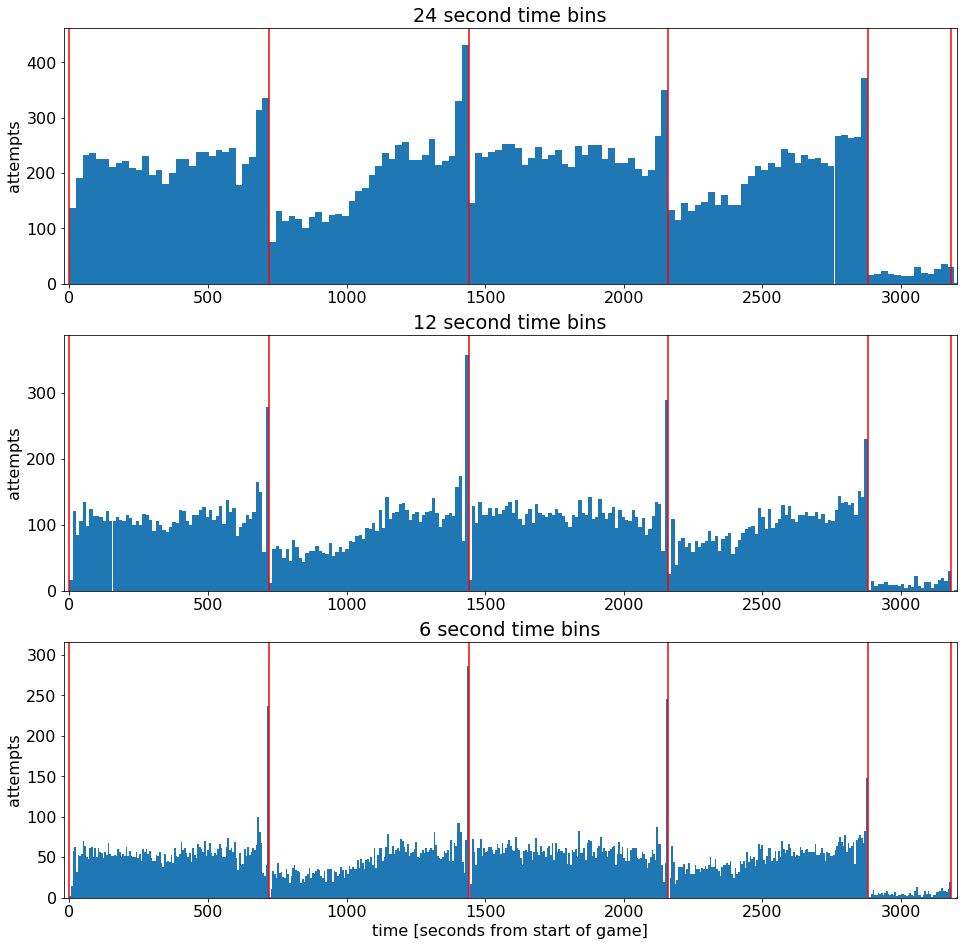

In [7]:
# plot the shot attempts as a function of time (from start of game) with several different binnings
plt.rcParams['figure.figsize'] = (16, 16)
plt.rcParams['font.size'] = 16

binsSizes = [24,12,6]

plt.figure();
for k, binSizeInSeconds in enumerate(binsSizes):
    timeBins = np.arange(0,60*(4*12+3*5),binSizeInSeconds)+0.01
    attemptsAsFunctionOfTime, b = np.histogram(data['secondsFromGameStart'], bins=timeBins)     
    
    maxHeight = max(attemptsAsFunctionOfTime) + 30
    barWidth = 0.999*(timeBins[1]-timeBins[0])
    plt.subplot(len(binsSizes),1,k+1); 
    plt.bar(timeBins[:-1],attemptsAsFunctionOfTime, align='edge', width=barWidth); plt.title(str(binSizeInSeconds) + ' second time bins')
    plt.vlines(x=[0,12*60,2*12*60,3*12*60,4*12*60,4*12*60+5*60,4*12*60+2*5*60,4*12*60+3*5*60], ymin=0,ymax=maxHeight, colors='r')
    plt.xlim((-20,3200)); plt.ylim((0,maxHeight)); plt.ylabel('attempts')
plt.xlabel('time [seconds from start of game]')

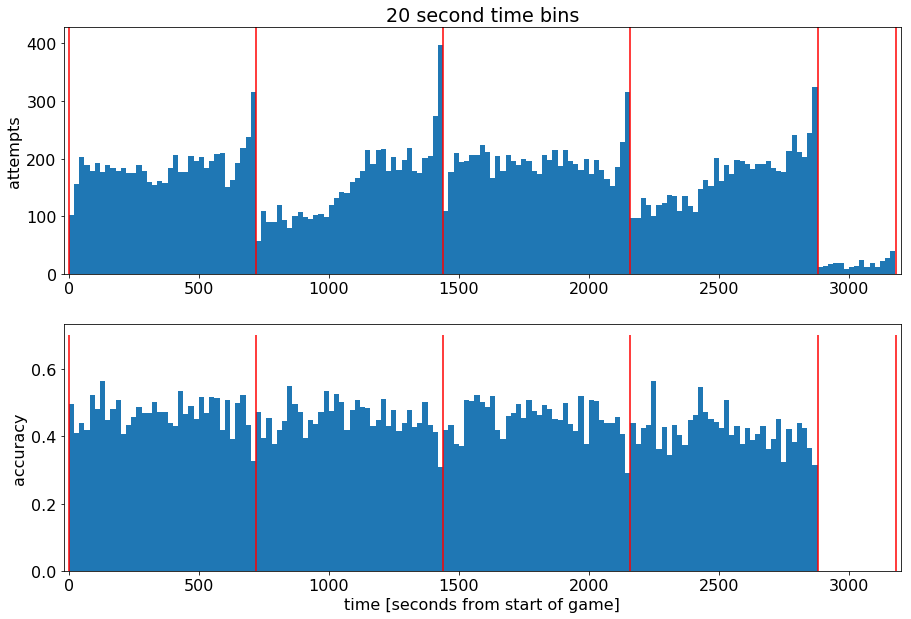

In [8]:
#%% plot the accuracy as a function of time
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 16

binSizeInSeconds = 20
timeBins = np.arange(0,60*(4*12+3*5),binSizeInSeconds)+0.01
attemptsAsFunctionOfTime,     b = np.histogram(data['secondsFromGameStart'], bins=timeBins)     
madeAttemptsAsFunctionOfTime, b = np.histogram(data.loc[data['shot_made_flag']==1,'secondsFromGameStart'], bins=timeBins)     
attemptsAsFunctionOfTime[attemptsAsFunctionOfTime < 1] = 1
accuracyAsFunctionOfTime = madeAttemptsAsFunctionOfTime.astype(float)/attemptsAsFunctionOfTime
accuracyAsFunctionOfTime[attemptsAsFunctionOfTime <= 50] = 0 # zero accuracy in bins that don't have enough samples

maxHeight = max(attemptsAsFunctionOfTime) + 30
barWidth = 0.999*(timeBins[1]-timeBins[0])

plt.figure();
plt.subplot(2,1,1); plt.bar(timeBins[:-1],attemptsAsFunctionOfTime, align='edge', width=barWidth); 
plt.xlim((-20,3200)); plt.ylim((0,maxHeight)); plt.ylabel('attempts'); plt.title(str(binSizeInSeconds) + ' second time bins')
plt.vlines(x=[0,12*60,2*12*60,3*12*60,4*12*60,4*12*60+5*60,4*12*60+2*5*60,4*12*60+3*5*60], ymin=0,ymax=maxHeight, colors='r')
plt.subplot(2,1,2); plt.bar(timeBins[:-1],accuracyAsFunctionOfTime, align='edge', width=barWidth); 
plt.xlim((-20,3200)); plt.ylabel('accuracy'); plt.xlabel('time [seconds from start of game]')
plt.vlines(x=[0,12*60,2*12*60,3*12*60,4*12*60,4*12*60+5*60,4*12*60+2*5*60,4*12*60+3*5*60], ymin=0.0,ymax=0.7, colors='r')

## ここでガウス分布学習モデル
- Now let's continue our initial exploration and examine the spatial location aspect of kobe's shots
we'll do this by building a gaussian mixture model that tries to summerize Kobe's shot locations compactly
- 和訳：さて、最初の探査を続けて、神戸のショットの空間的位置の側面を調べてみよう。
神戸のシュート位置をコンパクトにサマライズするガウス混合モデルを構築することでこれを行います


In [9]:
#%% cluster the shot attempts of kobe using GMM on their location
numGaussians = 13
gaussianMixtureModel = mixture.GaussianMixture(n_components=numGaussians, covariance_type='full', 
                                               init_params='kmeans', n_init=50, 
                                               verbose=0, random_state=5)
gaussianMixtureModel.fit(data.loc[:,['loc_x','loc_y']])

# add the GMM cluster as a field in the dataset
data['shotLocationCluster'] = gaussianMixtureModel.predict(data.loc[:,['loc_x','loc_y']])

### mixture.GaussianMixtureの引数
- n_components : 作成したい正規分布の数
- covariance_type {'full'（default）、 'tied'、 'diag'、 'spherical'}
- init_params {'kmeans'、 'random'}、デフォルトは 'kmeans'です。
- n_init int、デフォルトは1。
- verbose:整数。デフォルトは0です。詳細出力を有効にします。1の場合、現在の初期化と各反復ステップを出力します。1より大きい場合は、対数確率と各ステップに必要な時間も出力します。

### fitさせているデータ
X軸・Y軸の座標軸から放ったシュートを全サンプル数分fitさせている。

### 最後にDataFrameに追加

In [16]:
display(data.head(10))
display(data.loc[:,['loc_x','loc_y']].head(10))

,index,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,...,matchup,opponent,shot_id,game_date_DT,dayOfWeek,dayOfYear,secondsFromPeriodEnd,secondsFromPeriodStart,secondsFromGameStart,shotLocationCluster
0,1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,...,LAL @ POR,POR,2,2000-10-31,1,305,622,98,98,0
1,2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,...,LAL @ POR,POR,3,2000-10-31,1,305,465,255,255,12
2,3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,...,LAL @ POR,POR,4,2000-10-31,1,305,412,308,308,1
3,4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,...,LAL @ POR,POR,5,2000-10-31,1,305,379,341,1061,2
4,5,Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,...,LAL @ POR,POR,6,2000-10-31,1,305,572,148,1588,0
5,6,Layup Shot,Layup,251,20000012,34.0443,0,0,-118.2698,8,...,LAL @ POR,POR,7,2000-10-31,1,305,532,188,1628,2
6,8,Jump Shot,Jump Shot,265,20000012,33.9363,-65,108,-118.3348,6,...,LAL @ POR,POR,9,2000-10-31,1,305,372,348,1788,12
7,9,Running Jump Shot,Jump Shot,294,20000012,33.9193,-33,125,-118.3028,3,...,LAL @ POR,POR,10,2000-10-31,1,305,216,504,1944,3
8,10,Jump Shot,Jump Shot,309,20000012,33.8063,-94,238,-118.3638,1,...,LAL @ POR,POR,11,2000-10-31,1,305,116,604,2044,10
9,11,Jump Shot,Jump Shot,4,20000019,33.9173,121,127,-118.1488,11,...,LAL vs. UTA,UTA,12,2000-11-01,2,306,660,60,60,1


,loc_x,loc_y
0,-157,0
1,-101,135
2,138,175
3,0,0
4,-145,-11
5,0,0
6,-65,108
7,-33,125
8,-94,238
9,121,127


In [10]:
#%% define draw functions (stealing shamelessly the draw_court() function from MichaelKrueger's excelent script)
# 描画関数を定義する (MichaelKrueger氏の素晴らしいスクリプトから draw_court() 関数を盗んだものです)

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one  # 描画する軸オブジェクトが提供されていない場合は、現在の軸オブジェクトを取得します。
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court #NBAバスケットボールコートの様々なパーツを作成する

    # Create the basketball hoop バスケットボールのフープを作成する
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value # フープの直径は18 "なので、半径は9 "です。
    # 7.5 in our coordinate system  我々の座標系では # 7.5
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard  # バックボードを作成する
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint  # ♪絵の具は
    # Create the outer box 0f the paint, width=16ft, height=19ft  # ペイントの外枠を作成します, width=16ft, height=19ft.
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft  # ペイントの内側にボックスを作成する, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc  #フリースロートップアークを作成します
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc  # ♪フリースローのボトムアークを作成します
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop  # 制限区域はフープの中心から半径4フィートの円弧です
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line  # ♪三点鎖線
    # Create the side 3pt lines, they are 14ft long before they begin to arc  # 3ptのサイドラインを作成します。
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop  # 3ptアーク - アークの中心はフープになり、アークはフープから23'9 "離れています。
    # I just played around with the theta values until they lined up with the  # シータ値と一致するまで、シータ値を弄ってみました 
    # threes  # ♪３Ｐ
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court  # センターコート
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes  # 軸にプロットするコート要素のリスト
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines  # ハーフコートライン、ベースライン、サイドアウトバウンドラインを引く
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes  # コート要素を軸に追加します。
    for element in court_elements:
        ax.add_patch(element)

    return ax

def Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages):
    
    fig, h = plt.subplots();
    for i, (mean, covarianceMatrix) in enumerate(zip(gaussianMixtureModel.means_, gaussianMixtureModel.covariances_)):
        # get the eigen vectors and eigen values of the covariance matrix  # get the eigen vectors and eigen values of covariance matrix.
        v, w = np.linalg.eigh(covarianceMatrix)
        v = 2.5*np.sqrt(v) # go to units of standard deviation instead of variance  # 分散の代わりに標準偏差の単位に移動します
        
        # calculate the ellipse angle and two axis length and draw it  # 楕円の角度と2軸の長さを計算して描画する
        u = w[0] / np.linalg.norm(w[0])    
        angle = np.arctan(u[1] / u[0])
        angle = 180 * angle / np.pi  # convert to degrees  # ♪度数に換算して
        currEllipse = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=ellipseColors[i])
        currEllipse.set_alpha(0.5)
        h.add_artist(currEllipse)
        h.text(mean[0]+7, mean[1]-1, ellipseTextMessages[i], fontsize=13, color='blue')

## 備忘録matplotlibに円や長方形の描画メソッドあり
circleやRectangleなど  

https://note.nkmk.me/python-matplotlib-patches-circle-rectangle/

## Draw the 2D Gaussians of Shot Attempts
Each elipse is the countour that represents 2.5 standard deviations away from the center of the gaussian Each number in blue represents the precent of shots taken from this gaussian out of all shots

Text(0.5,1,'shot attempts')

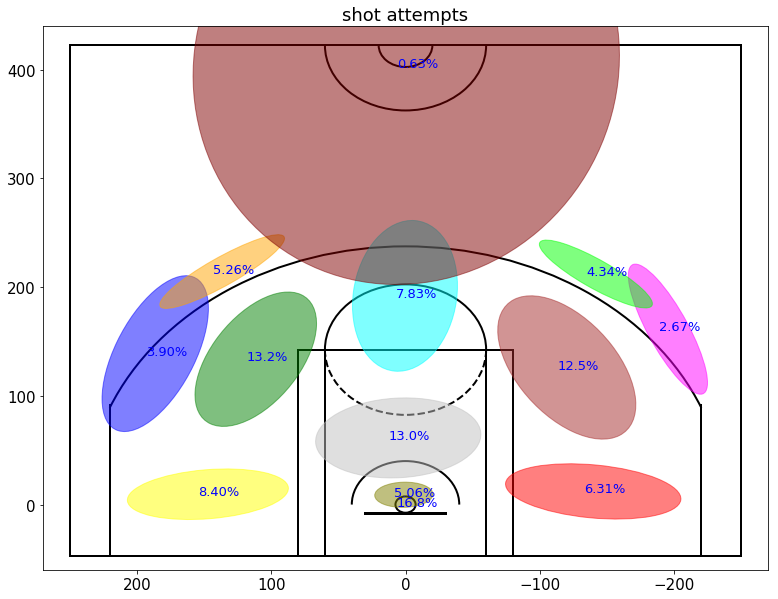

In [11]:
#%% show gaussian mixture elipses of shot attempts
plt.rcParams['figure.figsize'] = (13, 10)
plt.rcParams['font.size'] = 15

ellipseTextMessages = [str(100*gaussianMixtureModel.weights_[x])[:4]+'%' for x in range(numGaussians)]
ellipseColors = ['red','green','purple','cyan','magenta','yellow','blue','orange','silver','maroon','lime','olive','brown','darkblue']
Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages)
draw_court(outer_lines=True); plt.ylim(-60,440); plt.xlim(270,-270); plt.title('shot attempts')

## Youtube
[参考動画(引退試合ラスト3分)](https://www.youtube.com/watch?v=bYKAF6-RS84)

In [7]:
allData.sort_values(by=["game_date", "shot_id"], ascending=False)

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
22900,Pullup Jump shot,Jump Shot,488,21501228,33.8563,58,188,-118.2118,0,4,...,2PT Field Goal,Center(C),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2016-04-13,LAL vs. UTA,UTA,22901
22899,Pullup Jump shot,Jump Shot,482,21501228,33.9343,-232,110,-118.5018,0,4,...,3PT Field Goal,Left Side Center(LC),Above the Break 3,24+ ft.,1610612747,Los Angeles Lakers,2016-04-13,LAL vs. UTA,UTA,22900
22898,Pullup Jump shot,Jump Shot,479,21501228,33.9153,69,129,-118.2008,1,4,...,2PT Field Goal,Center(C),In The Paint (Non-RA),8-16 ft.,1610612747,Los Angeles Lakers,2016-04-13,LAL vs. UTA,UTA,22899
22897,Driving Layup Shot,Layup,475,21501228,34.0423,-7,2,-118.2768,1,4,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2016-04-13,LAL vs. UTA,UTA,22898
22896,Reverse Layup Shot,Layup,462,21501228,34.0503,6,-6,-118.2638,3,4,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2016-04-13,LAL vs. UTA,UTA,22897
22895,Layup Shot,Layup,447,21501228,34.0503,-7,-6,-118.2768,3,4,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2016-04-13,LAL vs. UTA,UTA,22896
22894,Turnaround Fadeaway shot,Jump Shot,442,21501228,34.0553,-83,-11,-118.3528,4,4,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2016-04-13,LAL vs. UTA,UTA,22895
22893,Pullup Jump shot,Jump Shot,431,21501228,33.9593,50,85,-118.2198,5,4,...,2PT Field Goal,Right Side(R),In The Paint (Non-RA),8-16 ft.,1610612747,Los Angeles Lakers,2016-04-13,LAL vs. UTA,UTA,22894
22892,Pullup Jump shot,Jump Shot,429,21501228,33.9333,-7,111,-118.2768,5,4,...,2PT Field Goal,Center(C),In The Paint (Non-RA),8-16 ft.,1610612747,Los Angeles Lakers,2016-04-13,LAL vs. UTA,UTA,22893
22891,Jump Shot,Jump Shot,424,21501228,33.9933,-1,51,-118.2708,6,4,...,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612747,Los Angeles Lakers,2016-04-13,LAL vs. UTA,UTA,22892


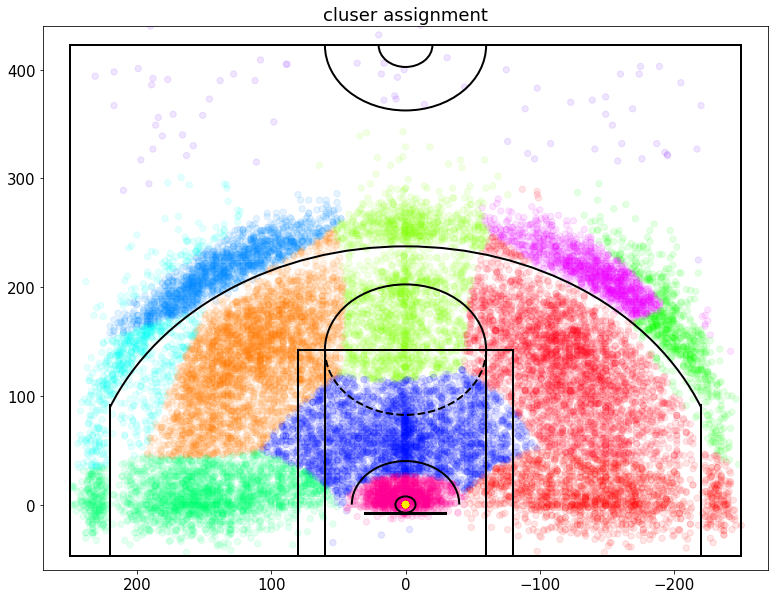

In [12]:
#%% just to make sure the gaussian model actually captures something, show the scatter and cluster assignment
plt.rcParams['figure.figsize'] = (13, 10)
plt.rcParams['font.size'] = 15

plt.figure(); draw_court(outer_lines=True); plt.ylim(-60,440); plt.xlim(270,-270); plt.title('cluser assignment')
plt.scatter(x=data['loc_x'],y=data['loc_y'],c=data['shotLocationCluster'],s=40,cmap='hsv',alpha=0.1)

Text(0.5,1,'shot accuracy')

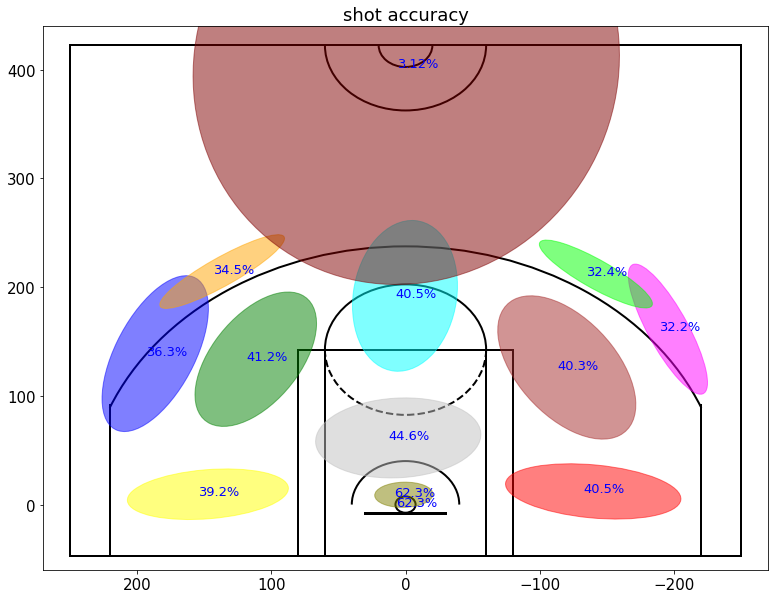

In [13]:
#%% for each cluster, calculate it's individual accuracy and plot it
plt.rcParams['figure.figsize'] = (13, 10)
plt.rcParams['font.size'] = 15

variableCategories = data['shotLocationCluster'].value_counts().index.tolist()

clusterAccuracy = {}
for category in variableCategories:
    shotsAttempted = np.array(data['shotLocationCluster'] == category).sum()
    shotsMade = np.array(data.loc[data['shotLocationCluster'] == category,'shot_made_flag'] == 1).sum()
    clusterAccuracy[category] = float(shotsMade)/shotsAttempted

ellipseTextMessages = [str(100*clusterAccuracy[x])[:4]+'%' for x in range(numGaussians)]
Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages)
draw_court(outer_lines=True); plt.ylim(-60,440); plt.xlim(270,-270); plt.title('shot accuracy')

## 描画部分
- ガウス混合分布でクラスター化された13地点（n_components : 13）にカラーで色付け  
正規分布・クラスタリング・描画を組み合わせてこんなことができるのかと感動。

- バスケットコートの描画部分がすごい（どのコードかは不明）

## その他
- 参考ノートブックの中には、例えばシュートを（入れた/外した）次のシュートの確率なども出ていました。入れたシュートの後のシュート確率は上がるのかということですね。  
いわゆるどのスポーツにも存在すると思いますが、「ゾーンに入る」という奴ですね。「ゾーンはない」と立証されていましたが・・・  
  
- [反証としてコービーが81点入れた試合を見てみま（ry...](https://www.youtube.com/watch?v=wV9CMVdY3dM)  
↑後半だけで50点以上入れているんですが、完全にゾーンに入ってます。

- 他のノートブックでもシュートセレクションを描画されていましたが、[画像](https://www.kaggleusercontent.com/kf/216119/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..NnSofLF5WNnzWGEJwypgrg.ev-KC8i8jXuYv3_pwcdg3IHXF8MmM4CmYet5J_Mjnosf-sxEeX-ggqw4AbIl-letzoLkZHsbkogjEQhf8hUz5HzqJdiszPr0FHgd9-sJzar9CUYG1q-dQJavscFZwoGkp8NYMeOlWC_uV1uDM-6gV2WR5fU17-NinyO96i3jmh7V96FifkEORVTX2oJ2gkWwG91VpfrIXu_92RZCqqU34crlSGjYP0JqPuTJe4XWJ-BhBjgST29UFmgQeaMTj9OBMAdqeefkJONcj8zn8_RUhFWAceuhtdFmC9BLW4LP-g-ohfaPCLOz_GfbXplaBkzk1H4IeBw5QhKkQvt907DiqcqfZnwxb-a7NGSZGfpC2aJGCBBk6aoOgTQVj40t9br35oCg_Y6AwOxqkUsRZVRNzsOZuk1y_jdYKRBjcGVIpwSFPX3CceAEZsk0uTB3s4pexJBPSDa3dg1da7Ji5d5eMFRWBOsmZpRGFsgIx-Stjqg47nC9TTDrC3-C24YbGKz47xgRGv-cVwHUS5vtfxWYnIWGZSPHlB1-2yxcTMvKsDBSSzC_v9CDtRZ5iHGDk3CNx5Ig9_Tk9URHdmChm11zxxW16ExDDfB9z-8WE1gBjEtQNwxKqeg79Ysg7SRs7V4GNjhkz4TNvS5nJMXExMkJzg.Uj7WNNV1Zhy_P2dHn-PfNw/__results___files/__results___2_0.png)こんな感じなので、このノートブックの凄さがわかります。

## 考察
- 得意なシュートポジションなどを予測できる。対戦する選手や監督として対策が立てやすい

- 少し延長した話ですが、デニス・ロドマンというリバウンダー（桜木花道のモデル）。ロドマンはリバウンドを取るために、対戦選手のシュートの傾向をビデオで研究し、「シュートが外れたときはどこのポジションにいた方が良い」「スクリーンアウトをかけたほうがいいか否か」などの判断をしていたようです。そういったものにも転用できるのではと思った。

- あるいは、サッカーに転回すると「デルピエロゾーン」なるものがあります。本当に得意なゾーンというのは存在するのか？など、名フリーキッカーの得意ゾーンなども検証できそう（そもそもデータセットが存在するかなど知りません）